# Spectrum Anomaly Detection for Optical Network Monitoring using Deep Unsupervised Learning

**Authors:** [Carlos Natalino](https://www.chalmers.se/en/staff/Pages/Carlos-Natalino-Da-Silva.aspx)\*, Aleksejs Udalcovs\*\*, Lena Wosinska\*, Oskars Ozolins\*\*, [Marija Furdek](https://www.chalmers.se/en/staff/Pages/Marija-Furdek-Prekratic.aspx)\*

\* Department of Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden (e-mail: carlos.natalino@chalmers.se, wosinska@chalmers.se, furdek@chalmers.se).

\*\* RISE Research Institutes of Sweden, Kista, Sweden (e-mail: aleksejs.udalcovs@ri.se, oskars.ozolins@ri.se).

## Training the autoencoder

This code creates and trains the autoencoder.

In [1]:
# code imports
import os
import numpy as np
import imageio
import pickle

from sklearn.model_selection import train_test_split

import pandas as pd

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

In [2]:
base_folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc'

classes = ['NoNeigh',
           '0dB_50GHz',
           '6dB_50GHz',
           '0dB_37.5GHz',
           '3dB_43.75GHz',
           '-3dB_43.75GHz']
folders = ['/NoJamming/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_0dB_Gap_50GHz/images',
           '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_6dB_Gap_50GHz/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_0dB_Gap_37.5GHz/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_3dB_Gap_43.75GHz/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_-3dB_Gap_43.75GHz/images']

folder = base_folder + '/NoJamming/images'
num_images = len(os.listdir(folder))

In [3]:
X = np.zeros((num_images * len(folders), 614, 614, 3))
X_grayscale = np.zeros((num_images  * len(folders), 614, 614))
Y = np.zeros((num_images * len(folders)))

print('loading images...')
for idc, case in enumerate(folders[:2]):
    folder = base_folder + case
    print('\t',case)
    
    # setting the class id
    Y[idc*num_images:(idc+1)*num_images] = idc
    # importing the images folder
    for i, file in enumerate(os.listdir(folder)):
        img = imageio.imread(folder + '/' + file)
        new_image = img[131:745, 277:891, :]
        X[i, :, :, :] = new_image
        X_grayscale[i, :, :] = new_image[..., :,1]

print('done...')

loading images...
	 /NoJamming/images
	 /Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_0dB_Gap_50GHz/images
done...


### Separating train and testing and normalizing them

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_grayscale, Y, stratify=Y, test_size=0.5, random_state=42)

# normalizing pixels in the range [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshaping images
x_train = x_train.reshape((len(x_train), 614, 614, 1)) # shapes the inputs for what the encoder is expecting
x_test = x_test.reshape((len(x_test), 614, 614, 1))

print(x_train.shape)
print(x_test.shape)

(300, 614, 614, 1)
(300, 614, 614, 1)


# Implementing the autoencoder

In [6]:
input_img = Input(shape=(614, 614, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(1, (6, 6), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (6, 6), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(1, (6, 6), activation='relu', padding='same')(x)
x = MaxPooling2D((3, 3), padding='same')(x)


x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(1, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(1, (6, 6), activation='relu', padding='same')(x)
x = UpSampling2D((3, 3))(x)

x = Conv2D(1, (6, 6), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (6, 6), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (6, 6), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

optm = optimizers.RMSprop(lr=0.001)

autoencoder.compile(optimizer=optm, loss='mse', metrics=['mse', 'msle'])
autoencoder.summary()

plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='figures/model.png')
try:
    plot_model(autoencoder, show_shapes=True, show_layer_names=True, to_file='figures/model.pdf')
except ValueError as e:
    print('error', e)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 614, 614, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 614, 614, 1)       37        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 307, 307, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 307, 307, 16)      592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 154, 154, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 154, 154, 1)       577       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 1)         0     

### Training the autoencoder

In [8]:
history = autoencoder.fit(x_train, x_train,
                epochs=300,
                batch_size=64,
                shuffle=True,
                verbose=1,
                validation_data=(x_test, x_test))

Epoch 1/300
5/5 [==============================] - 83s 17s/step - loss: 0.2484 - mse: 0.2484 - msle: 0.1509 - val_loss: 0.2471 - val_mse: 0.2471 - val_msle: 0.1541
Epoch 2/300
5/5 [==============================] - 2s 450ms/step - loss: 0.2466 - mse: 0.2466 - msle: 0.1499 - val_loss: 0.2458 - val_mse: 0.2458 - val_msle: 0.1534
Epoch 3/300
5/5 [==============================] - 2s 441ms/step - loss: 0.2455 - mse: 0.2455 - msle: 0.1493 - val_loss: 0.2447 - val_mse: 0.2447 - val_msle: 0.1527
Epoch 4/300
5/5 [==============================] - 2s 446ms/step - loss: 0.2445 - mse: 0.2445 - msle: 0.1487 - val_loss: 0.2436 - val_mse: 0.2436 - val_msle: 0.1521
Epoch 5/300
5/5 [==============================] - 2s 444ms/step - loss: 0.2436 - mse: 0.2436 - msle: 0.1482 - val_loss: 0.2426 - val_mse: 0.2426 - val_msle: 0.1516
Epoch 6/300
5/5 [==============================] - 2s 447ms/step - loss: 0.2428 - mse: 0.2428 - msle: 0.1477 - val_loss: 0.2417 - val_mse: 0.2417 - val_msle: 0.1510
Epoch 7/300

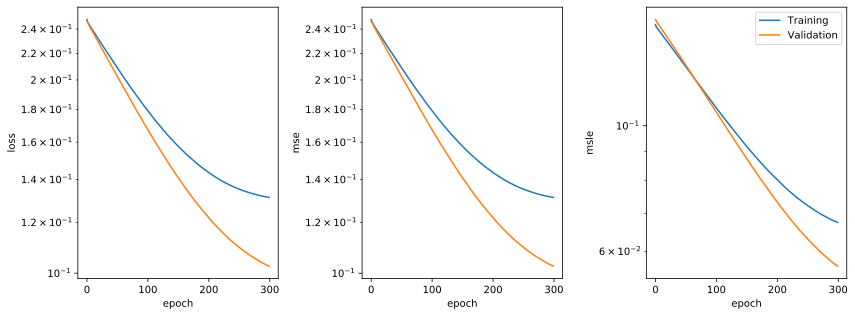

In [9]:
# plot here the evolution
metrics = [x for x in history.history.keys() if 'val' not in x]
plt.figure(figsize=(12, 4.5))
for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    plt.semilogy(history.history[metric][:300])
    plt.semilogy(history.history['val_' + metric][:300])
    # plt.title('model loss')
    plt.ylabel(metric)
    plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('figures/training_autoencoder.pdf')
plt.savefig('figures/training_autoencoder.svg')
plt.show()
plt.close()

with open('models/training_history_autoencoder.h5', 'wb') as f:
    pickle.dump(history.history, f)

In [10]:
# saving autoencoder to file
autoencoder.save('models/autoencoder.h5')

In [11]:
# loading and validating architecture
loaded= load_model('models/autoencoder.h5')
layer = len(loaded.layers) // 2
encoder = Model(loaded.input, loaded.layers[layer].output)

loaded.summary()
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 614, 614, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 614, 614, 1)       37        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 307, 307, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 307, 307, 16)      592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 154, 154, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 154, 154, 1)       577       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 1)         0     